[RX(6.180258045101926, wires=[0]), CNOT(wires=[0, 1]), T(wires=[1]), CZ(wires=[1, 3]), Hadamard(wires=[2]), Hadamard(wires=[3]), CNOT(wires=[3, 2]), T(wires=[4]), SWAP(wires=[4, 0]), RY(0.8512906812794604, wires=[0]), RZ(3.3221225668272556, wires=[1]), S(wires=[2]), Toffoli(wires=[tensor(3, requires_grad=True), tensor(1, requires_grad=True), 2]), RZ(3.0592737834856925, wires=[3]), RY(1.2469074457698013, wires=[4]), RX(1.8101966860218972, wires=[0]), Toffoli(wires=[tensor(3, requires_grad=True), tensor(4, requires_grad=True), 0]), T(wires=[1]), Toffoli(wires=[tensor(4, requires_grad=True), tensor(0, requires_grad=True), 1]), T(wires=[2]), Toffoli(wires=[tensor(4, requires_grad=True), tensor(3, requires_grad=True), 2]), RZ(3.699418427208776, wires=[3]), SWAP(wires=[3, 2]), RX(3.1430100367986964, wires=[4])]
[expval(Y(1) @ Y(2) @ X(3))]
['__class__', '__class_getitem__', '__contains__', '__copy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__e

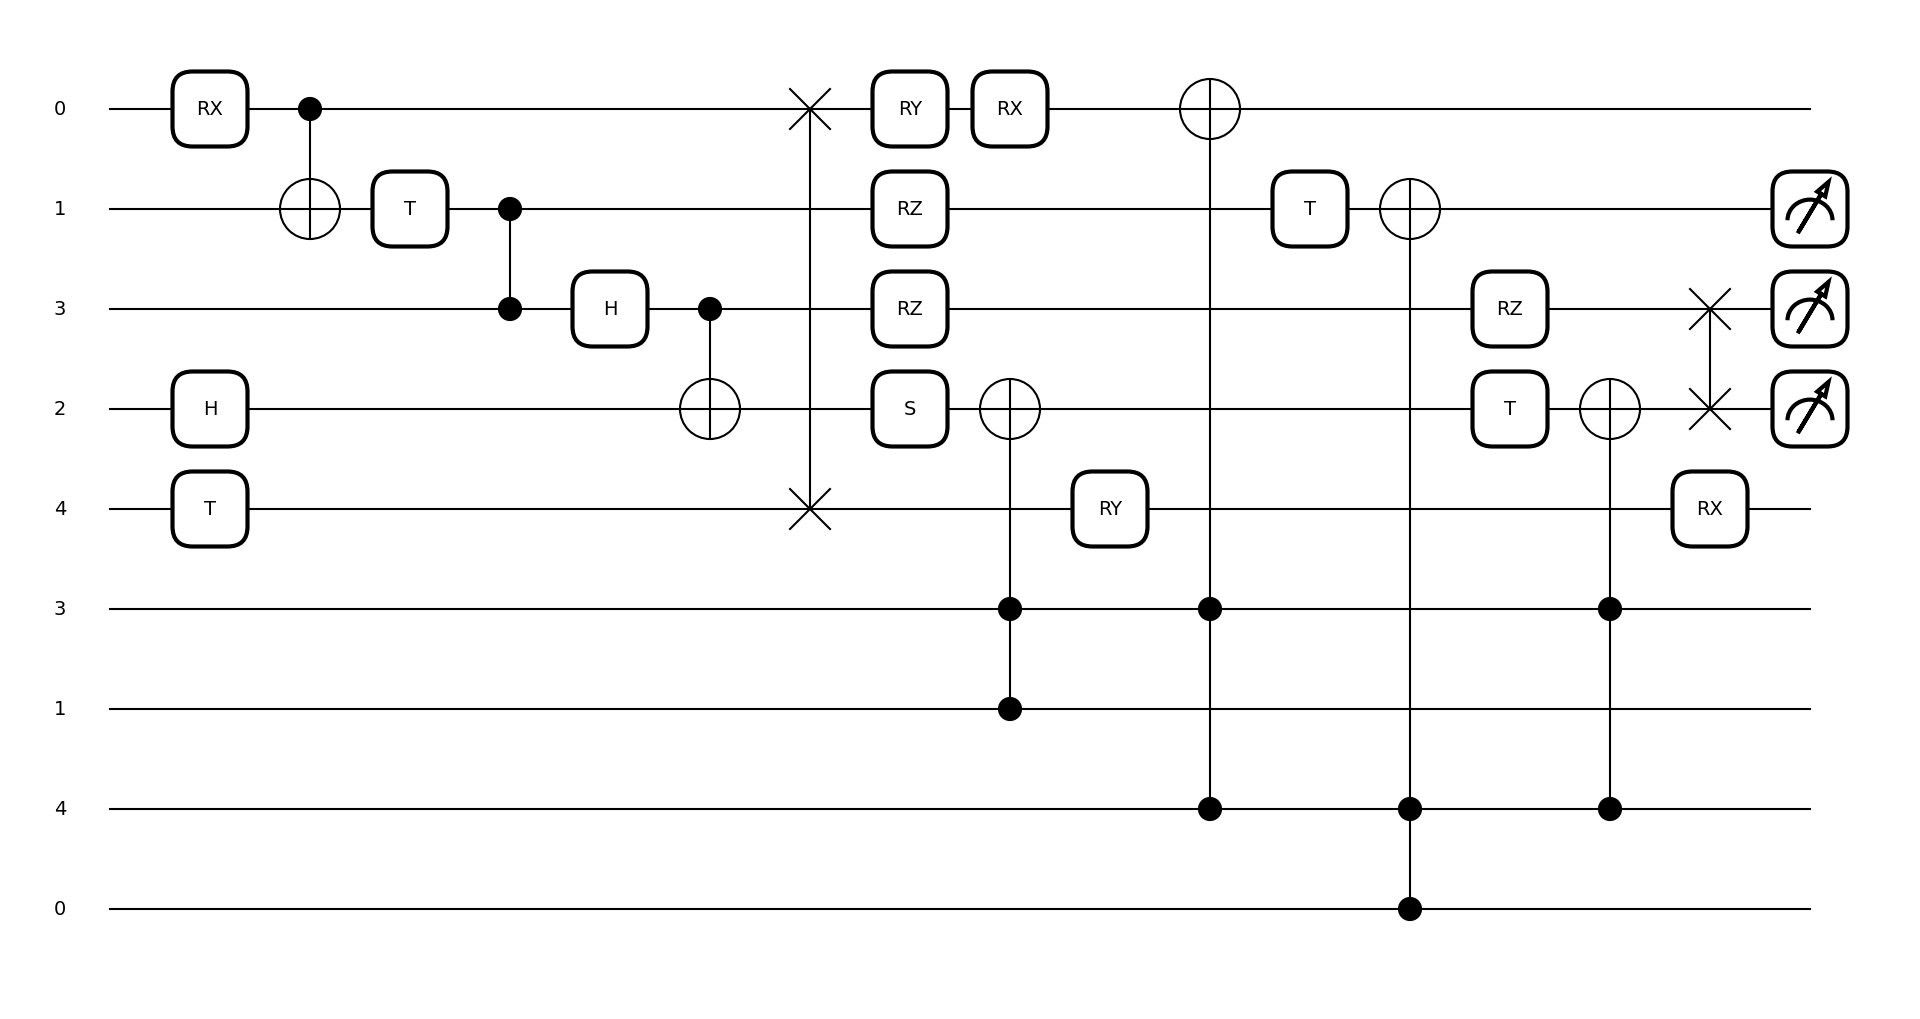

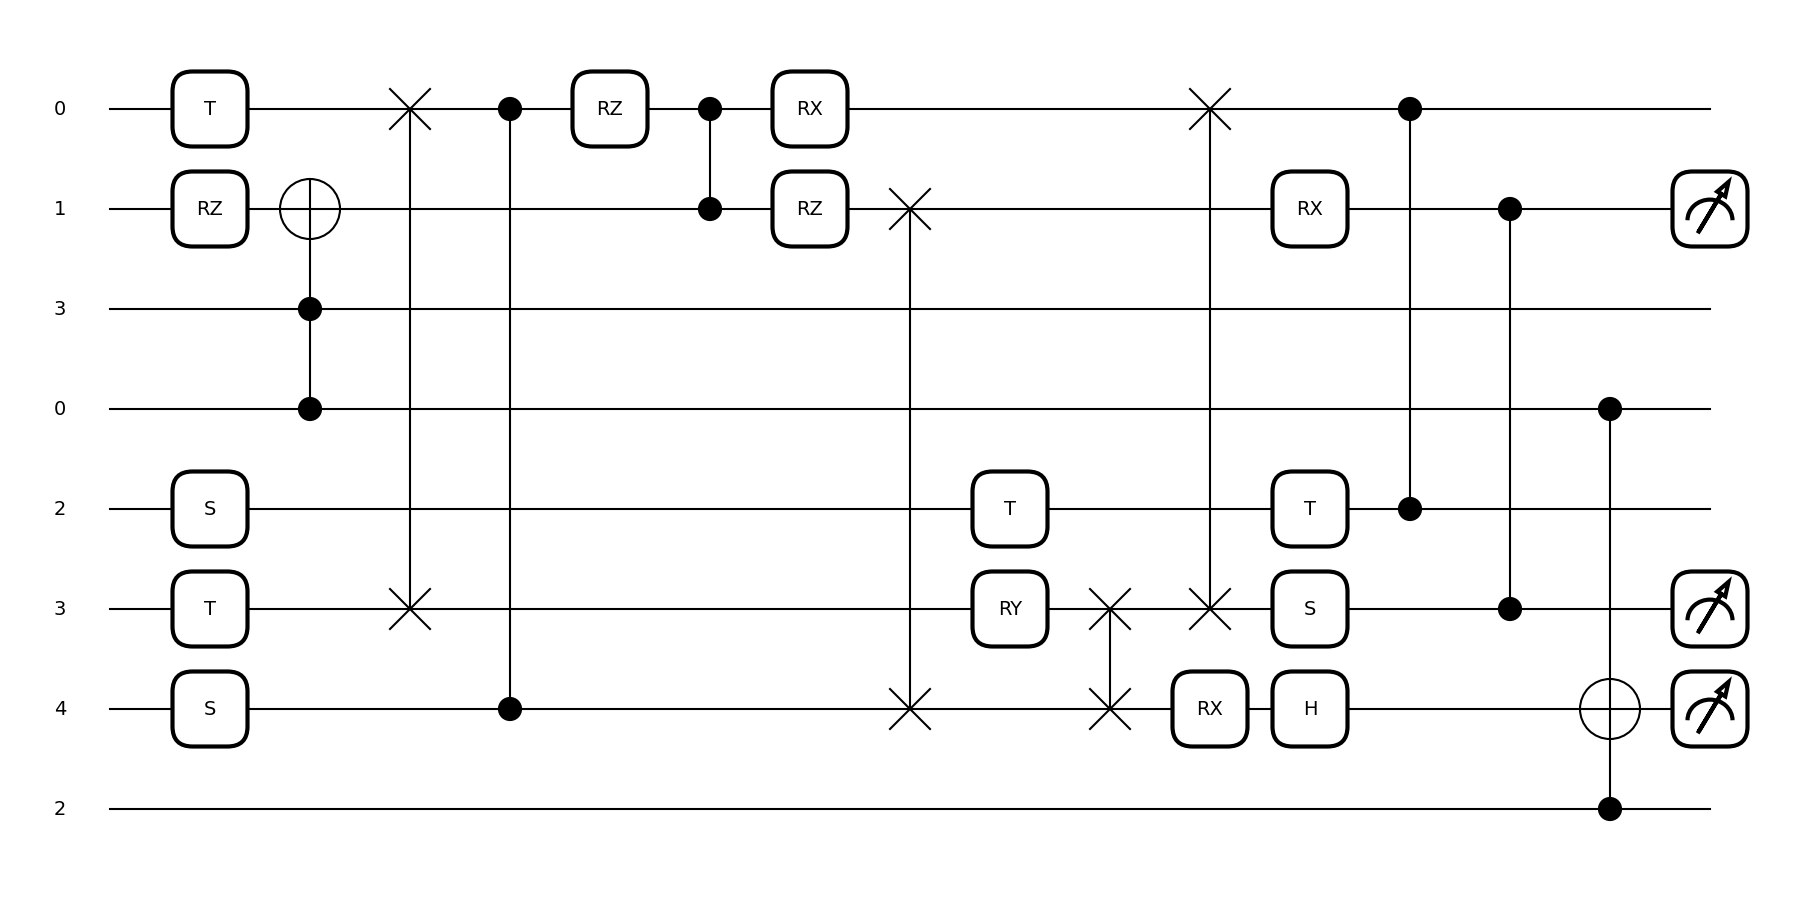

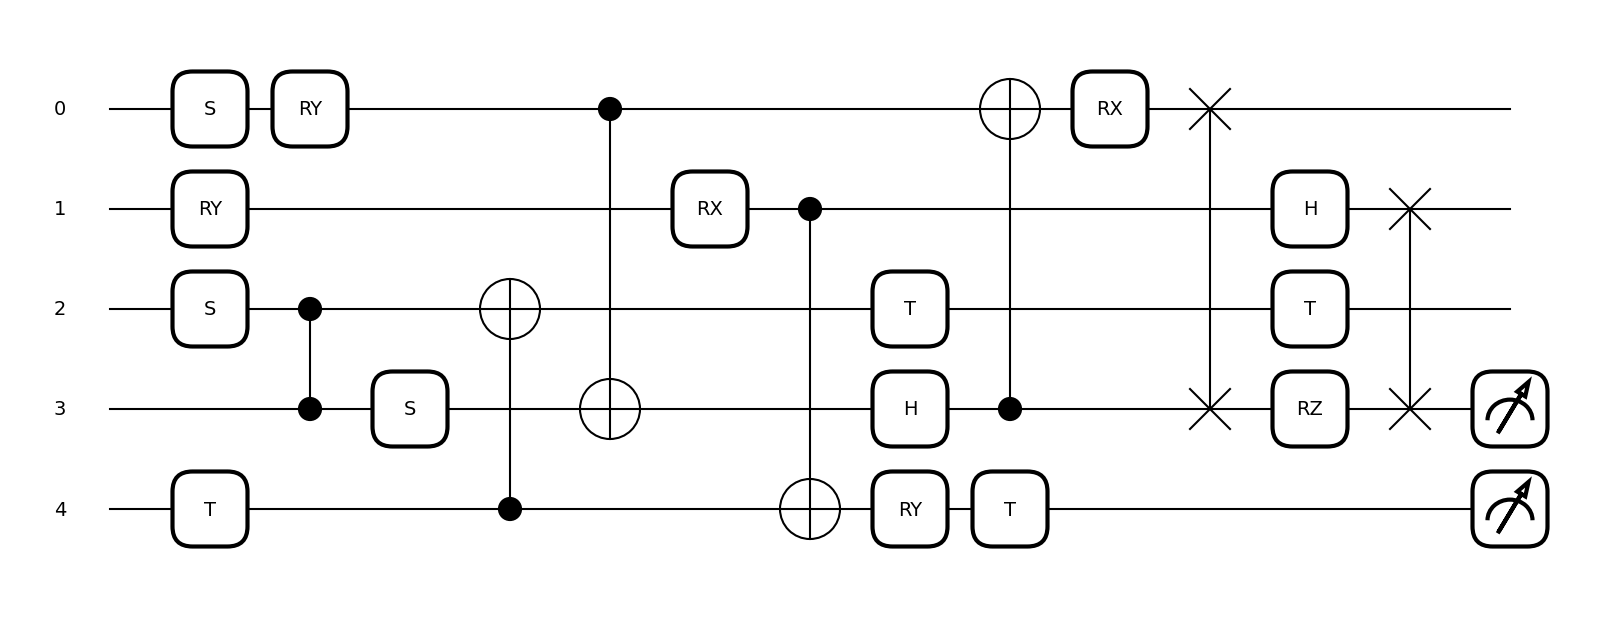

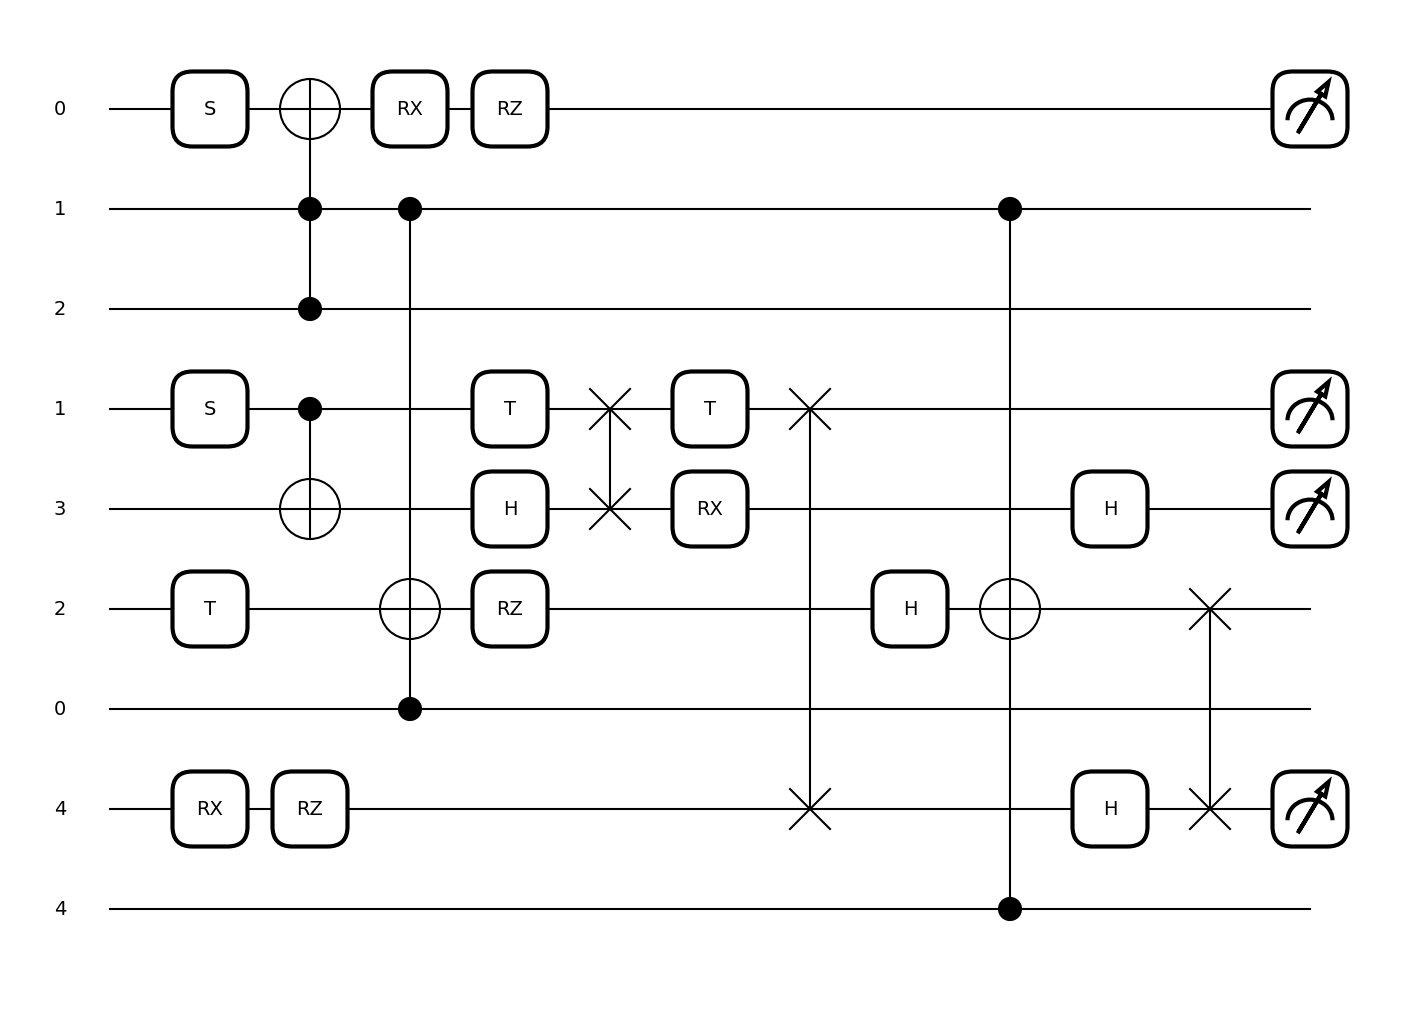

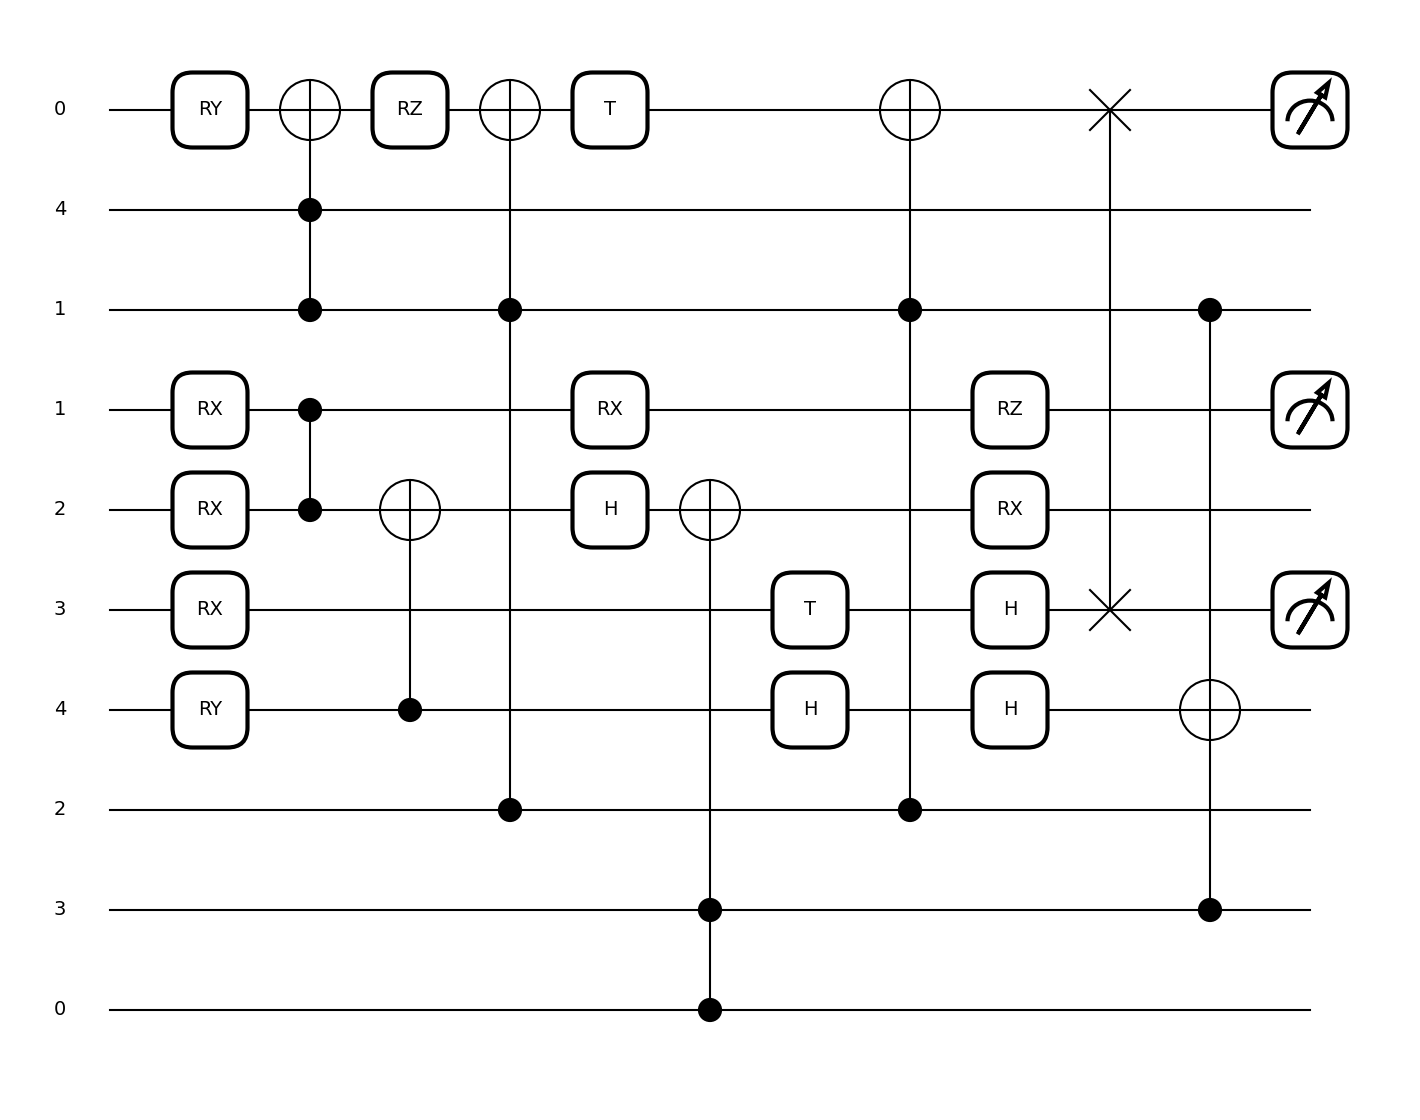

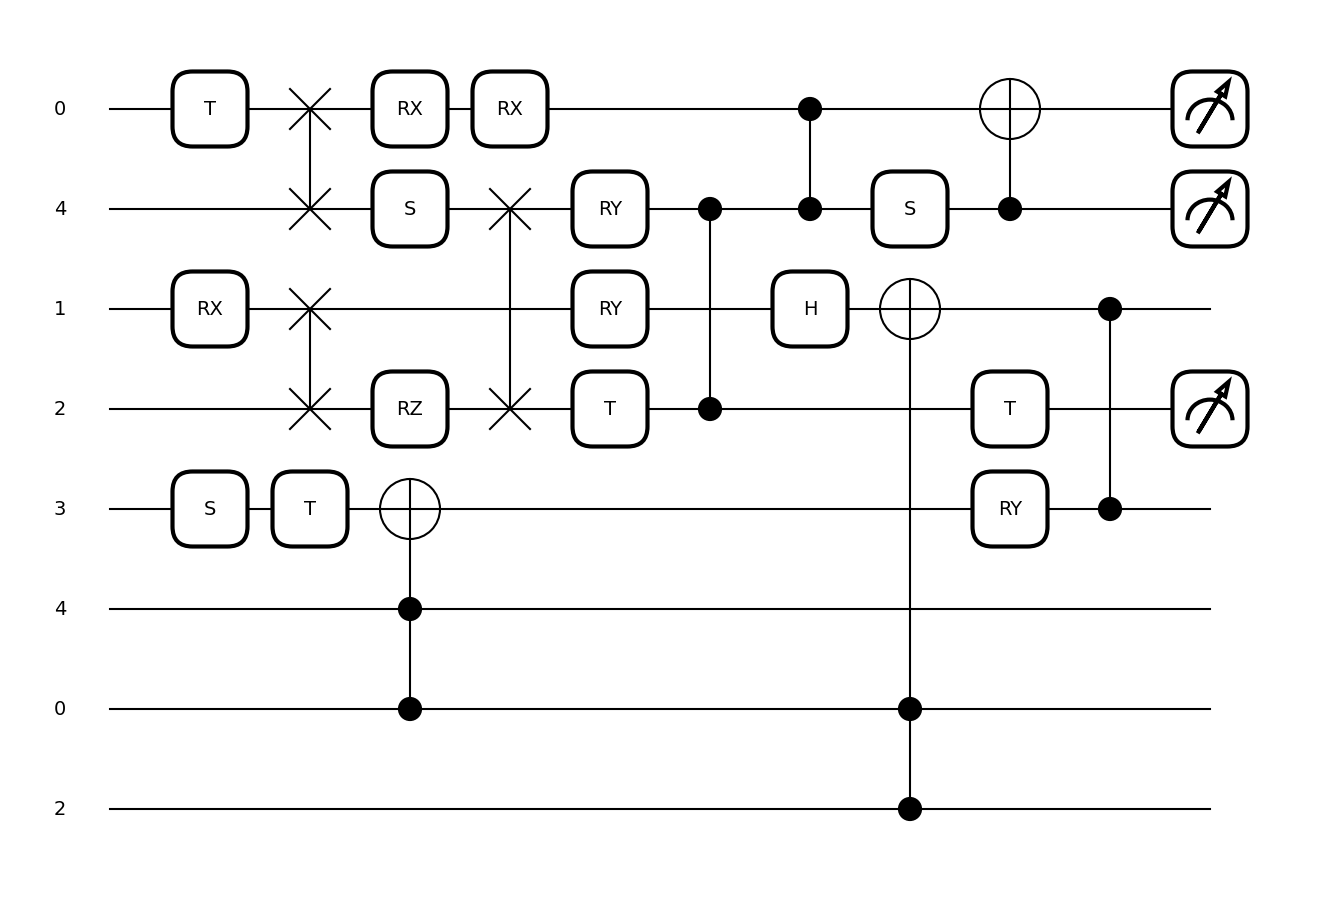

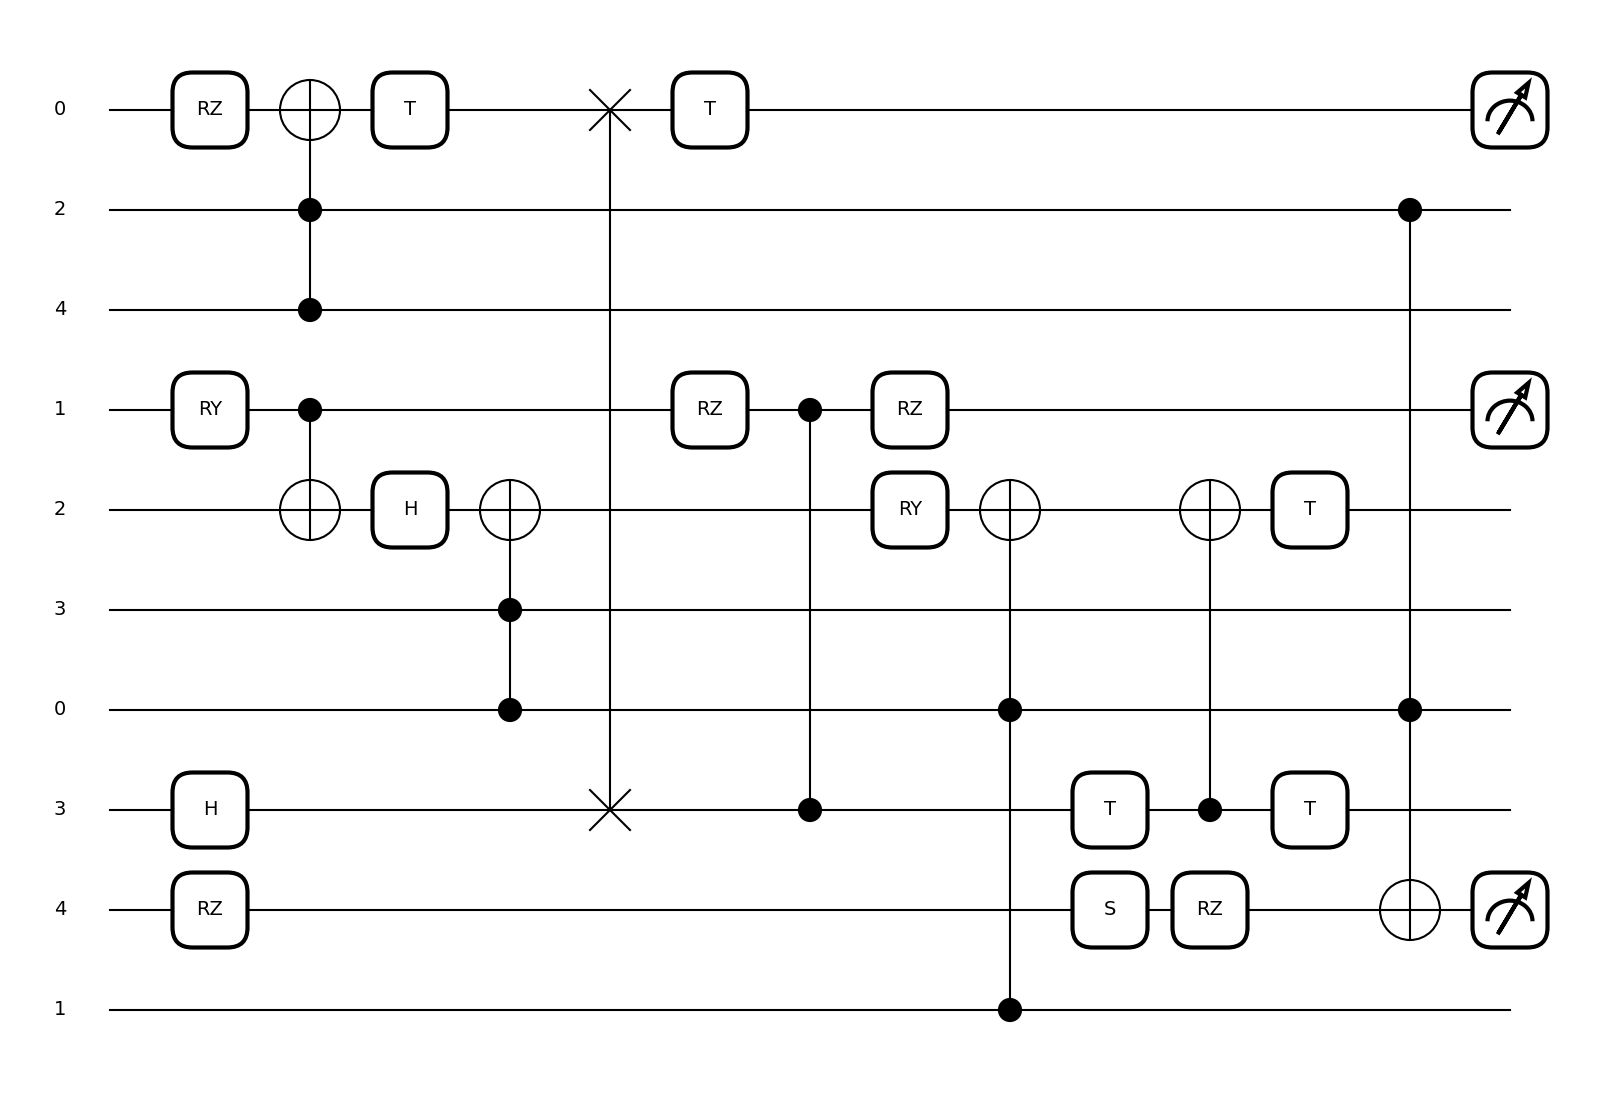

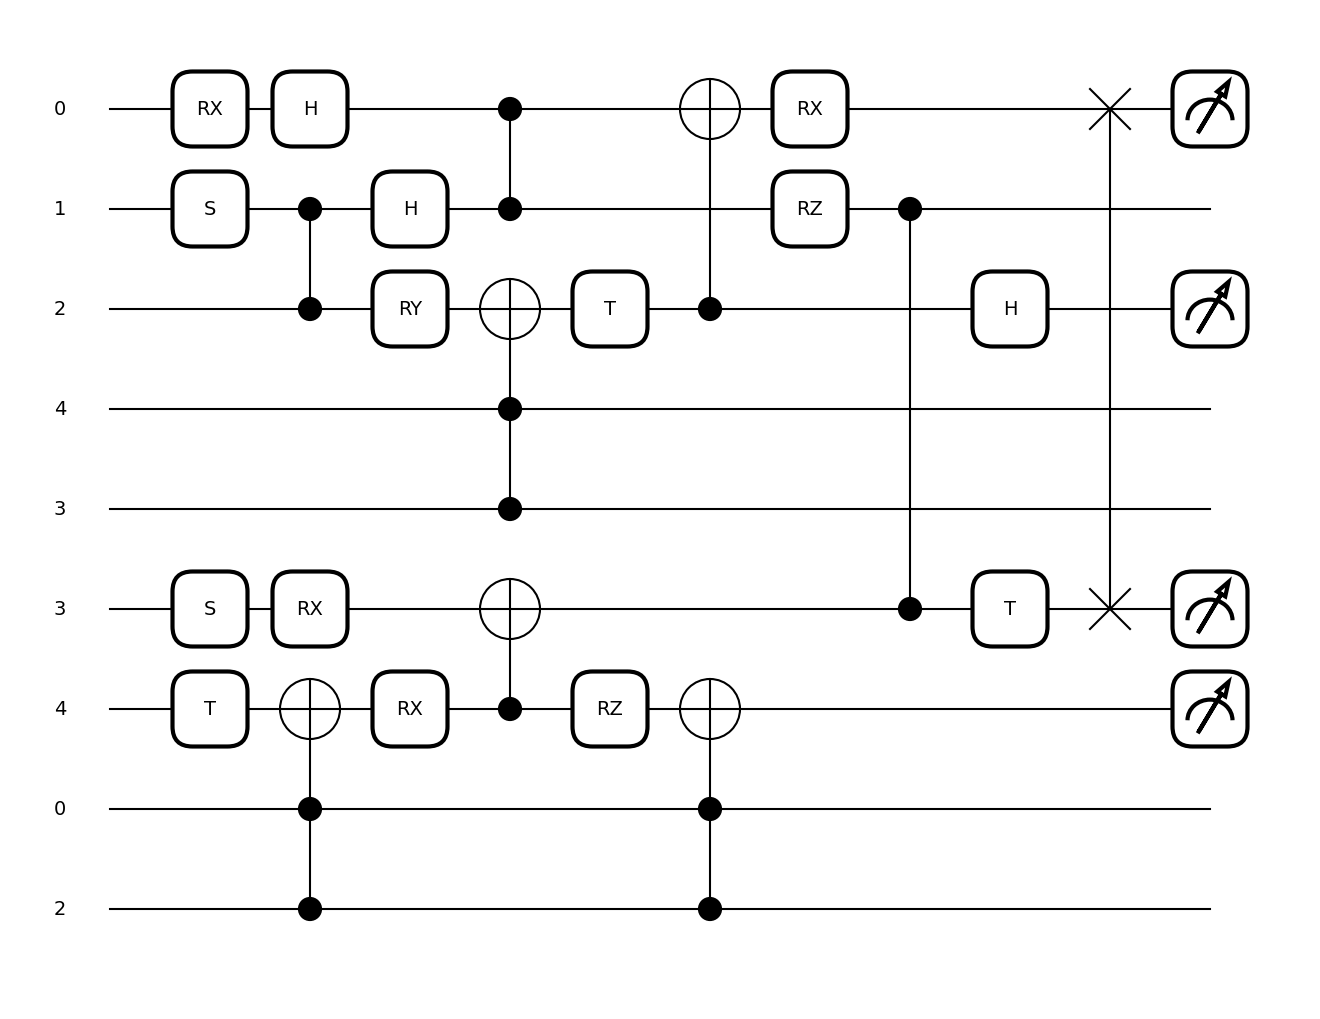

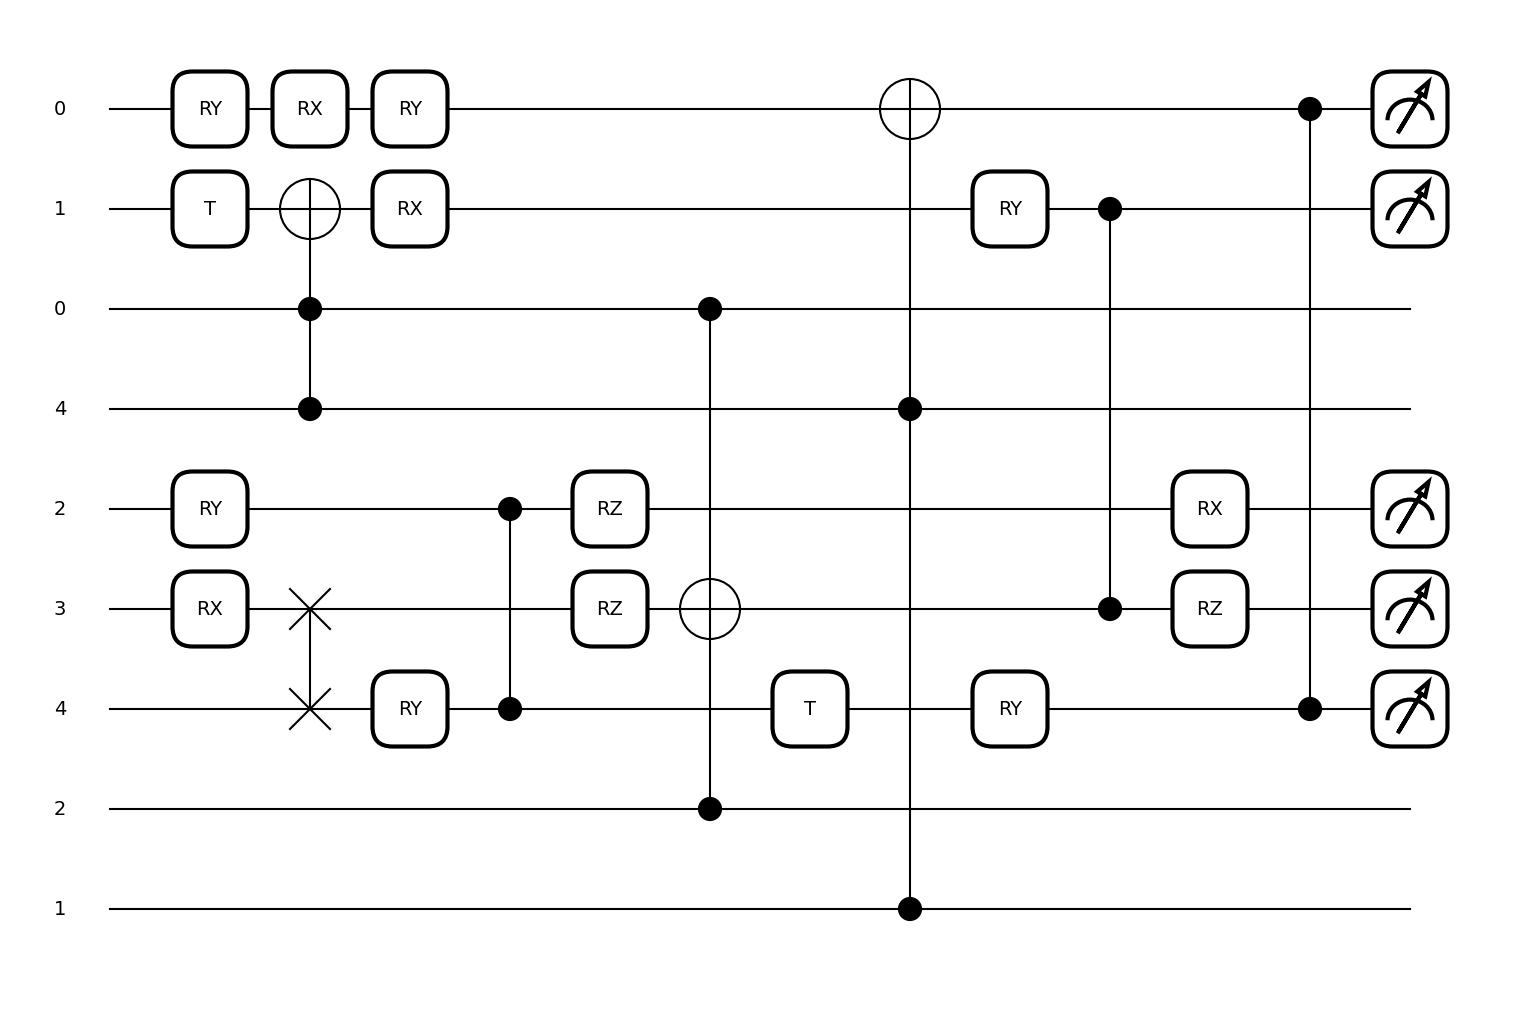

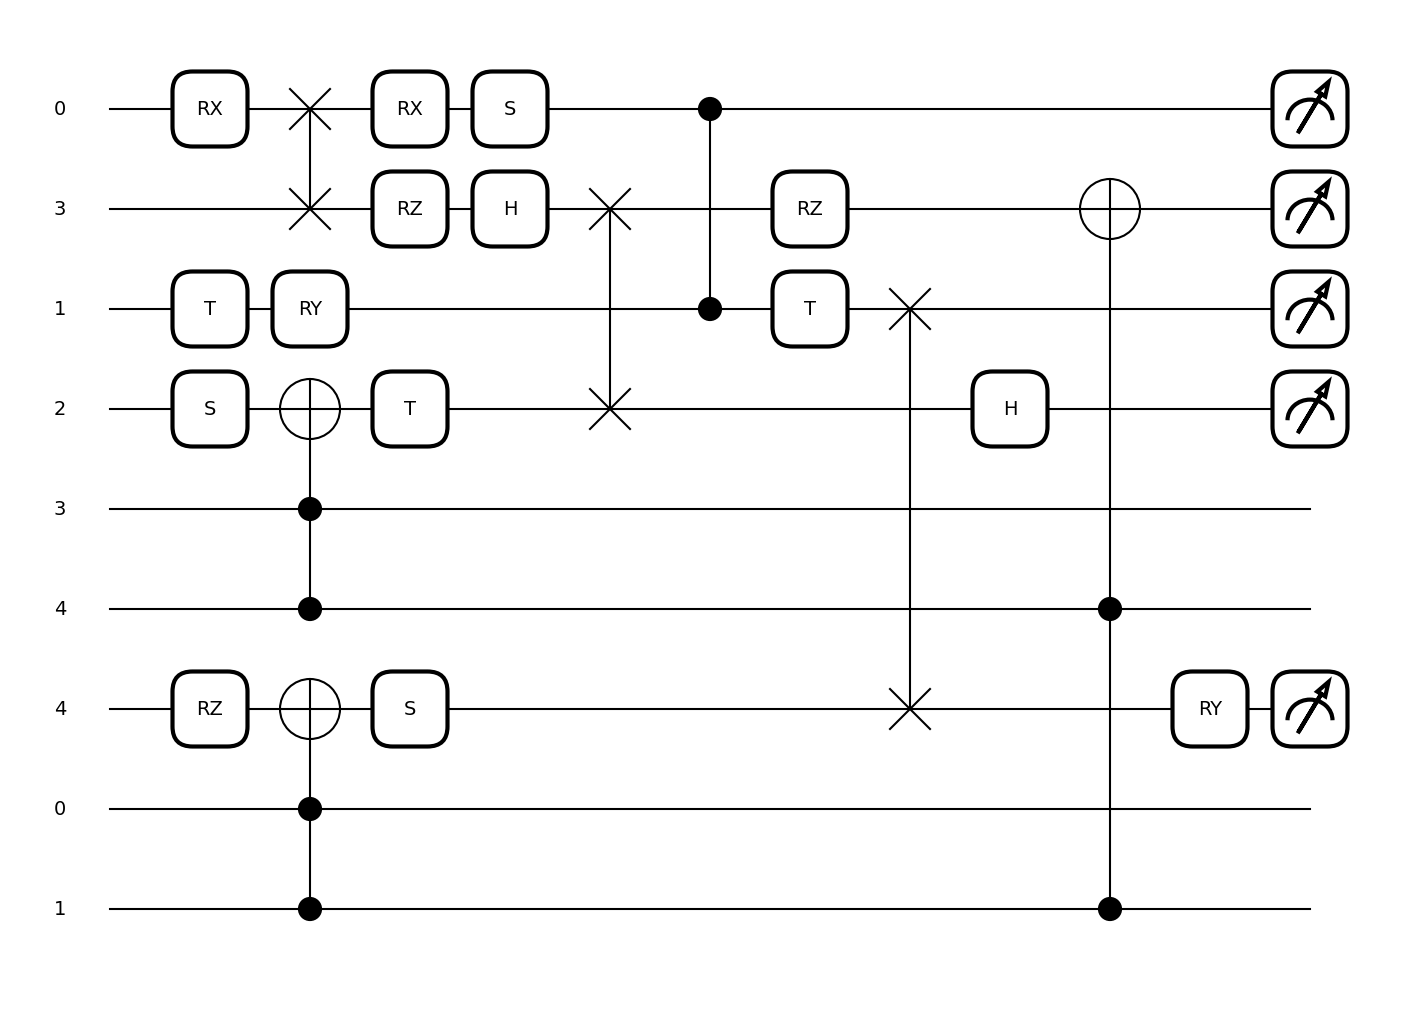

In [ ]:
from collections import Counter

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

def encode_tape_sequence(tape: qml.tape.QuantumTape):
    encoding = []
    gate_dict = {"RX": 101, "RY": 102, "RZ": 103, "H": 104, "CNOT": 105, "CZ": 106, "SWAP": 107, "Toffoli": 108}
    meas_dict = {"Prod": 201, "PauliX": 202, "PauliY": 203, "PauliZ": 204}
    for op in tape.operations:
        if op.name in gate_dict:
            encoded_op = (float(gate_dict[op.name]), [float(w) for w in op.wires], [float(p) for p in op.parameters])
            encoding.append(encoded_op)
    for m in tape.measurements:
        meas = m.obs
        print("MEAS:", meas, type(meas))
        if isinstance(meas, (qml.PauliX, qml.PauliY, qml.PauliZ)):
            # Single Pauli operator case (e.g., X, Y, Z, etc.)
            print(f"Single Pauli operator: {meas}, qubit(s): {meas.wires}")
            encoding.append(meas_dict[meas.name])
            encoding.append([300 + w for w in meas.wires])
        elif isinstance(meas, qml.ops.op_math.Prod):
            print("I FOUND A PROD")
            # Loop over each term in the Prod operator
            encoding.append(meas_dict["Prod"])
            for term in meas:
                if isinstance(term, (qml.PauliX, qml.PauliY, qml.PauliZ)):
                    # Print the Pauli operator and the qubit(s) it acts on
                    print(f"Operator: {term}, qubit(s): {term.wires}")
                    encoding.append(meas_dict[term.name])
                    encoding.append([300 + w for w in term.wires])
        else:
            raise ValueError("Unsupported measurement (only Pauli operators or Prod if them are supported)")
    return encoding

def random_circuit(qubits: int, depth: int, seed: int = None) -> qml.tape.QuantumTape:
    """
    Generate a random quantum circuit with the given number of qubits
    and the specified depth. The seed allows reproducible results.
    """
    if seed is not None:
        np.random.seed(seed)        
    gates1 = [qml.RX, qml.RY, qml.RZ, qml.Hadamard, qml.S, qml.T]
    angle_gates = {qml.RX, qml.RY, qml.RZ}
    gates2 = [qml.CNOT, qml.CZ, qml.SWAP]
    gates3 = [qml.Toffoli]
    bases = ['I', 'X', 'Y', 'Z']
    with qml.tape.QuantumTape() as tape:
        for layer in range(depth):
            for qubit in range(qubits):
                gate = np.random.choice(gates1)
                if gate in angle_gates:
                    angle = np.random.uniform(0, 2 * np.pi)
                    gate(angle, wires=qubit)
                else:
                    gate(wires=qubit)
                if np.random.rand() < 0.5:  # Multi-qubit gate addition probability
                    if qubits > 1 and np.random.rand() < 0.5:
                        gate = np.random.choice(gates2)
                        target = np.random.choice([q for q in range(qubits) if q != qubit])
                        gate(wires=[qubit, target])
                    elif qubits > 2:
                        gate = np.random.choice(gates3)
                        wire1, wire2 = np.random.choice([q for q in range(qubits) if q != qubit], size=2, replace=False)
                        gate(wires=[wire1, wire2, qubit])
        pauli_str = ''.join(np.random.choice(bases) for _ in range(qubits))
        qml.expval(qml.pauli.string_to_pauli_word(pauli_str))
    return tape

dev = qml.device("default.qubit", wires=2)

qubits = 5
circuits = [random_circuit(qubits, 3) for i in range(10)]
for c in circuits:
    fig, ax = qml.drawer.tape_mpl(c)
    print(c.operations)
    print(c.measurements)
    print(dir(c))
    print(encode_tape_sequence(c))
    print(30 * "-")
plt.show()